# DLS Reading Python Code
## last edit by Alison 8/1/2023

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re
import calendar

#from google.colab import drive
#drive.mount('/content/drive')

# Load Data

In [2]:
df = pd.read_excel('/Users/alison/Library/CloudStorage/GoogleDrive-alui@berkeley.edu/My Drive/Research/AL Data/B3P170 - R18 and CF LUV + LNP/2023-07-27 - DLS/2023-07-27 lnp.xlsx')
df.head(2)

,Measurement Date and Time,Record Number,Sample Name,Intensities[1] (Percent),Intensities[2] (Percent),Intensities[3] (Percent),Intensities[4] (Percent),Intensities[5] (Percent),Intensities[6] (Percent),Intensities[7] (Percent),...,Numbers[62] (Percent),Numbers[63] (Percent),Numbers[64] (Percent),Numbers[65] (Percent),Numbers[66] (Percent),Numbers[67] (Percent),Numbers[68] (Percent),Numbers[69] (Percent),Numbers[70] (Percent),Diffusion Coefficient (µ²/s)
0,"Thursday, July 27, 2023 8:42:10 PM",1,306oi10 LNP pH 7.4 0.1X 1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.69
1,"Thursday, July 27, 2023 8:44:43 PM",2,306oi10 LNP pH 7.4 0.1X 2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.78


# Extract Size Data in nm

In [3]:
size = df.filter(regex=r'Size').drop_duplicates().T.reset_index().rename(columns={0:"Diameter (nm)"})
size['DLS index'] = size['index'].str.findall(r'\d+').explode()
size = size.drop(columns='index')
size.head(2)

,Diameter (nm),DLS index
0,0.4000,1
1,0.4632,2


# Format sample names

In [4]:
info = pd.DataFrame(df.loc[:,['Measurement Date and Time','Sample Name']].copy(deep=True))
info['Triplicate'] = info['Sample Name'].str.strip().str[-1]
info['title'] = info['Sample Name'].str.rstrip(r'123 ')
info.head()

,Measurement Date and Time,Sample Name,Triplicate,title
0,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X
1,"Thursday, July 27, 2023 8:44:43 PM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X
2,"Thursday, July 27, 2023 8:47:16 PM",306oi10 LNP pH 7.4 0.1X 3,3,306oi10 LNP pH 7.4 0.1X
3,"Friday, July 28, 2023 6:32:18 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X
4,"Friday, July 28, 2023 6:34:41 PM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X


# Format date and time 

In [5]:
# extract date and time information
info = info.join(pd.DataFrame(info["Measurement Date and Time"].str.findall(r'([A-Z][a-z]*), ([A-Z][a-z]*) (\d\d?), (\d{4}) (\d\d?:\d\d?:\d\d [AP]M)').explode().to_list(), columns=["day of week","month","day","year","time"]))

# replace string month to numerical month to be read by datetime function
d = dict((v,k) for k,v in enumerate(calendar.month_name))
info["month"] = info.month.map(d)

# convert columns to integer datatype
info["day"] = info["day"].astype(int)
info["month"] = info["month"].astype(int)
info["year"] = info["year"].astype(int)

info.sample(3)

,Measurement Date and Time,Sample Name,Triplicate,title,day of week,month,day,year,time
2,"Thursday, July 27, 2023 8:47:16 PM",306oi10 LNP pH 7.4 0.1X 3,3,306oi10 LNP pH 7.4 0.1X,Thursday,7,27,2023,8:47:16 PM
17,"Monday, July 31, 2023 12:38:00 PM",R18 POPC LUV pH 7.4 0.025X 3,3,R18 POPC LUV pH 7.4 0.025X,Monday,7,31,2023,12:38:00 PM
18,"Monday, July 31, 2023 12:47:06 PM",R18 POPG LUV pH 7.4 0.025X 1,1,R18 POPG LUV pH 7.4 0.025X,Monday,7,31,2023,12:47:06 PM


In [6]:
info["date"] = pd.to_datetime(info.loc[:,["year","month","day"]])
info

,Measurement Date and Time,Sample Name,Triplicate,title,day of week,month,day,year,time,date
0,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,Thursday,7,27,2023,8:42:10 PM,2023-07-27
1,"Thursday, July 27, 2023 8:44:43 PM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X,Thursday,7,27,2023,8:44:43 PM,2023-07-27
2,"Thursday, July 27, 2023 8:47:16 PM",306oi10 LNP pH 7.4 0.1X 3,3,306oi10 LNP pH 7.4 0.1X,Thursday,7,27,2023,8:47:16 PM,2023-07-27
3,"Friday, July 28, 2023 6:32:18 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,Friday,7,28,2023,6:32:18 PM,2023-07-28
4,"Friday, July 28, 2023 6:34:41 PM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X,Friday,7,28,2023,6:34:41 PM,2023-07-28
5,"Friday, July 28, 2023 6:37:04 PM",306oi10 LNP pH 7.4 0.1X 3,3,306oi10 LNP pH 7.4 0.1X,Friday,7,28,2023,6:37:04 PM,2023-07-28
6,"Monday, July 31, 2023 11:19:00 AM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,Monday,7,31,2023,11:19:00 AM,2023-07-31
7,"Monday, July 31, 2023 11:21:33 AM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X,Monday,7,31,2023,11:21:33 AM,2023-07-31
8,"Monday, July 31, 2023 11:24:07 AM",306oi10 LNP pH 7.4 0.1X 3,3,306oi10 LNP pH 7.4 0.1X,Monday,7,31,2023,11:24:07 AM,2023-07-31
9,"Monday, July 31, 2023 11:39:53 AM",CF POPG LUV 1X 1,1,CF POPG LUV 1X,Monday,7,31,2023,11:39:53 AM,2023-07-31


# Find all unique titles and dates

In [7]:
samples = info.loc[:,["title","date"]].drop_duplicates()

In [8]:
samples["id"] = np.arange(0,samples.shape[0])
samples

,title,date,id
0,306oi10 LNP pH 7.4 0.1X,2023-07-27,0
3,306oi10 LNP pH 7.4 0.1X,2023-07-28,1
6,306oi10 LNP pH 7.4 0.1X,2023-07-31,2
9,CF POPG LUV 1X,2023-07-31,3
12,CF POPC LUV 1X,2023-07-31,4
15,R18 POPC LUV pH 7.4 0.025X,2023-07-31,5
18,R18 POPG LUV pH 7.4 0.025X,2023-07-31,6


## Compute days since first sample for each unique title

In [9]:
startdate = pd.pivot_table(data=samples,
               index="title",
               values="date",
               aggfunc="min").rename(columns={"date" : "start date"})
startdate

,start date
title,
306oi10 LNP pH 7.4 0.1X,2023-07-27
CF POPC LUV 1X,2023-07-31
CF POPG LUV 1X,2023-07-31
R18 POPC LUV pH 7.4 0.025X,2023-07-31
R18 POPG LUV pH 7.4 0.025X,2023-07-31


In [10]:
samples = samples.merge(startdate, left_on="title",right_on="title")
samples["days since"] = samples["date"] - samples["start date"]
samples["days since"] = samples["days since"].apply(lambda x: x.days)
samples

,title,date,id,start date,days since
0,306oi10 LNP pH 7.4 0.1X,2023-07-27,0,2023-07-27,0
1,306oi10 LNP pH 7.4 0.1X,2023-07-28,1,2023-07-27,1
2,306oi10 LNP pH 7.4 0.1X,2023-07-31,2,2023-07-27,4
3,CF POPG LUV 1X,2023-07-31,3,2023-07-31,0
4,CF POPC LUV 1X,2023-07-31,4,2023-07-31,0
5,R18 POPC LUV pH 7.4 0.025X,2023-07-31,5,2023-07-31,0
6,R18 POPG LUV pH 7.4 0.025X,2023-07-31,6,2023-07-31,0


In [11]:
info = info.merge(samples, 
           left_on=["title","date"],
           right_on=["title","date"]
          )
info

,Measurement Date and Time,Sample Name,Triplicate,title,day of week,month,day,year,time,date,id,start date,days since
0,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,Thursday,7,27,2023,8:42:10 PM,2023-07-27,0,2023-07-27,0
1,"Thursday, July 27, 2023 8:44:43 PM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X,Thursday,7,27,2023,8:44:43 PM,2023-07-27,0,2023-07-27,0
2,"Thursday, July 27, 2023 8:47:16 PM",306oi10 LNP pH 7.4 0.1X 3,3,306oi10 LNP pH 7.4 0.1X,Thursday,7,27,2023,8:47:16 PM,2023-07-27,0,2023-07-27,0
3,"Friday, July 28, 2023 6:32:18 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,Friday,7,28,2023,6:32:18 PM,2023-07-28,1,2023-07-27,1
4,"Friday, July 28, 2023 6:34:41 PM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X,Friday,7,28,2023,6:34:41 PM,2023-07-28,1,2023-07-27,1
5,"Friday, July 28, 2023 6:37:04 PM",306oi10 LNP pH 7.4 0.1X 3,3,306oi10 LNP pH 7.4 0.1X,Friday,7,28,2023,6:37:04 PM,2023-07-28,1,2023-07-27,1
6,"Monday, July 31, 2023 11:19:00 AM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,Monday,7,31,2023,11:19:00 AM,2023-07-31,2,2023-07-27,4
7,"Monday, July 31, 2023 11:21:33 AM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X,Monday,7,31,2023,11:21:33 AM,2023-07-31,2,2023-07-27,4
8,"Monday, July 31, 2023 11:24:07 AM",306oi10 LNP pH 7.4 0.1X 3,3,306oi10 LNP pH 7.4 0.1X,Monday,7,31,2023,11:24:07 AM,2023-07-31,2,2023-07-27,4
9,"Monday, July 31, 2023 11:39:53 AM",CF POPG LUV 1X 1,1,CF POPG LUV 1X,Monday,7,31,2023,11:39:53 AM,2023-07-31,3,2023-07-31,0


# Create intensity dataframe

In [12]:
intensity = df.filter(regex=r'Sample Name|Intensities').set_index('Sample Name').T
intensity['DLS index'] = pd.Series(intensity.index).str.findall(r'\d+').explode().values
intensity.head(2)

Sample Name,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,CF POPG LUV 1X 1,...,CF POPC LUV 1X 1,CF POPC LUV 1X 2,CF POPC LUV 1X 3,R18 POPC LUV pH 7.4 0.025X 1,R18 POPC LUV pH 7.4 0.025X 2,R18 POPC LUV pH 7.4 0.025X 3,R18 POPG LUV pH 7.4 0.025X 1,R18 POPG LUV pH 7.4 0.025X 2,R18 POPG LUV pH 7.4 0.025X 3,DLS index
Intensities[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Intensities[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


## Join to "df_main"

In [13]:
df_main = intensity.melt(id_vars='DLS index', value_vars=intensity.columns, value_name='Intensity %')
df_main.head(2)

,DLS index,Sample Name,Intensity %
0,1,306oi10 LNP pH 7.4 0.1X 1,0.0
1,2,306oi10 LNP pH 7.4 0.1X 1,0.0


# Create number dataframe

In [14]:
number = df.filter(regex=r'Sample Name|Numbers').set_index('Sample Name').T
number['DLS index'] = pd.Series(number.index).str.findall(r'\d+').explode().values
number.head(2)

Sample Name,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,CF POPG LUV 1X 1,...,CF POPC LUV 1X 1,CF POPC LUV 1X 2,CF POPC LUV 1X 3,R18 POPC LUV pH 7.4 0.025X 1,R18 POPC LUV pH 7.4 0.025X 2,R18 POPC LUV pH 7.4 0.025X 3,R18 POPG LUV pH 7.4 0.025X 1,R18 POPG LUV pH 7.4 0.025X 2,R18 POPG LUV pH 7.4 0.025X 3,DLS index
Numbers[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Numbers[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


## Join to "df_main"

In [15]:
df_main = df_main.merge(number.melt(id_vars='DLS index', value_vars=number.columns, value_name='Number %'))
df_main.head(2)

,DLS index,Sample Name,Intensity %,Number %
0,1,306oi10 LNP pH 7.4 0.1X 1,0.0,0.0
1,1,306oi10 LNP pH 7.4 0.1X 1,0.0,0.0


# Merge in 'Size' and 'Info'

In [16]:
df_main = df_main.merge(size).merge(info)
df_main.head(2)

,DLS index,Sample Name,Intensity %,Number %,Diameter (nm),Measurement Date and Time,Triplicate,title,day of week,month,day,year,time,date,id,start date,days since
0,1,306oi10 LNP pH 7.4 0.1X 1,0.0,0.0,0.4,"Thursday, July 27, 2023 8:42:10 PM",1,306oi10 LNP pH 7.4 0.1X,Thursday,7,27,2023,8:42:10 PM,2023-07-27,0,2023-07-27,0
1,1,306oi10 LNP pH 7.4 0.1X 1,0.0,0.0,0.4,"Friday, July 28, 2023 6:32:18 PM",1,306oi10 LNP pH 7.4 0.1X,Friday,7,28,2023,6:32:18 PM,2023-07-28,1,2023-07-27,1


# Plot DLS Data

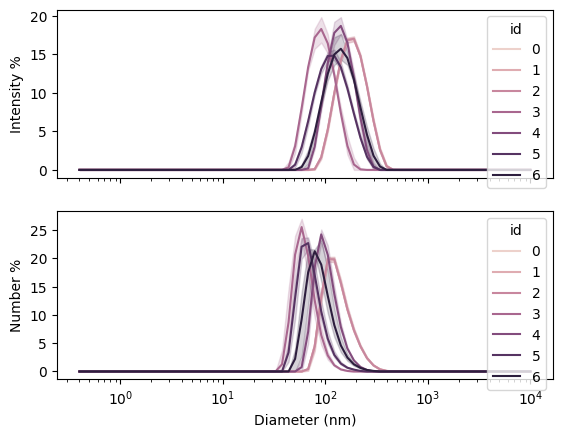

In [17]:
fig, ax = plt.subplots(2,1, sharex=True)

sns.lineplot(data=df_main,
             x="Diameter (nm)",
             y="Intensity %",
             hue="id",
             ax=ax[0])

sns.lineplot(data=df_main,
             x="Diameter (nm)",
             y="Number %",
             hue="id",
             ax=ax[1])

ax[0].set_xscale('log')

# Compute mean and mode

In [18]:
df_pivot = pd.pivot_table(data=df_main,
               index="id",
               values = ["Intensity %","Number %"],
               aggfunc = ["max"])
df_pivot.head()

max         
   Intensity % Number %
id                     
0         17.9     21.2
1         17.9     21.2
2         17.9     21.2
3         19.8     27.0
4         19.8     25.1

In [19]:
for i in df_pivot.index:
    
    df_pivot.loc[i, ('Diameter (nm)', 'Intensity %')] = df_main.loc[(df_main["id"] == i) &
                                                            (df_main["Intensity %"] == df_pivot.loc[i,('max',"Intensity %")])].loc[:,"Diameter (nm)"].values.mean()
    
    df_pivot.loc[i, ('Diameter (nm)', 'Number %')] = df_main.loc[(df_main["id"] == i) &
                                                            (df_main["Number %"] == df_pivot.loc[i,('max',"Number %")])].loc[:,"Diameter (nm)"].values.mean()
    
df_pivot.head()

max          Diameter (nm)         
   Intensity % Number %   Intensity % Number %
id                                            
0         17.9     21.2        190.10   105.70
1         17.9     21.2        190.10   105.70
2         17.9     21.2        190.10   105.70
3         19.8     27.0         91.28    58.77
4         19.8     25.1        141.80    91.28

In [20]:
df_pivot.columns = ["_".join(a) for a in df_pivot.columns.to_flat_index()]

In [21]:
df_pivot

,max_Intensity %,max_Number %,Diameter (nm)_Intensity %,Diameter (nm)_Number %
id,,,,
0,17.9,21.2,190.10,105.70
1,17.9,21.2,190.10,105.70
2,17.9,21.2,190.10,105.70
3,19.8,27.0,91.28,58.77
4,19.8,25.1,141.80,91.28
5,15.6,23.7,122.40,68.06
6,17.6,23.3,141.80,91.28


In [22]:
df_pivot = df_pivot.merge(samples.loc[:,["title","date","id","days since"]],
               left_on="id",
               right_on="id")

df_pivot

,id,max_Intensity %,max_Number %,Diameter (nm)_Intensity %,Diameter (nm)_Number %,title,date,days since
0,0,17.9,21.2,190.10,105.70,306oi10 LNP pH 7.4 0.1X,2023-07-27,0
1,1,17.9,21.2,190.10,105.70,306oi10 LNP pH 7.4 0.1X,2023-07-28,1
2,2,17.9,21.2,190.10,105.70,306oi10 LNP pH 7.4 0.1X,2023-07-31,4
3,3,19.8,27.0,91.28,58.77,CF POPG LUV 1X,2023-07-31,0
4,4,19.8,25.1,141.80,91.28,CF POPC LUV 1X,2023-07-31,0
5,5,15.6,23.7,122.40,68.06,R18 POPC LUV pH 7.4 0.025X,2023-07-31,0
6,6,17.6,23.3,141.80,91.28,R18 POPG LUV pH 7.4 0.025X,2023-07-31,0


<Axes: xlabel='title', ylabel='Diameter (nm)_Intensity %'>

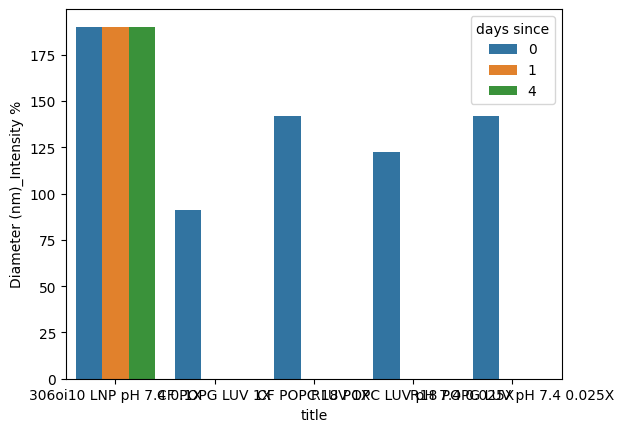

In [23]:
fig, ax = plt.subplots()

sns.barplot(data=df_pivot,
            x="title",
            y="Diameter (nm)_Intensity %",
            hue="days since")

In [24]:
y

NameError: name 'y' is not defined